$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
#device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/adihorowitz/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/adihorowitz/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/adihorowitz/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


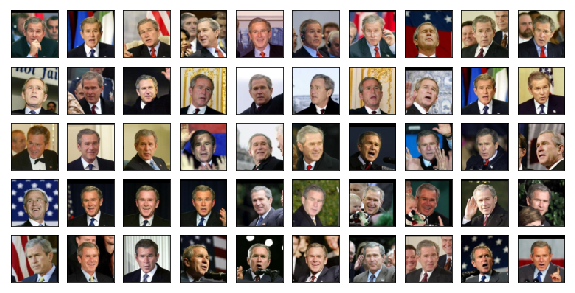

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 250, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=16000, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 250, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(1000, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([1,

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

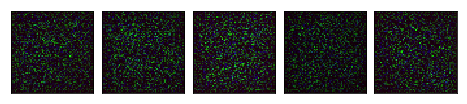

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 10, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.4, 0.999)}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.84it/s]
Discriminator loss: 0.39408689452444806
Generator loss:     5.008038086049697


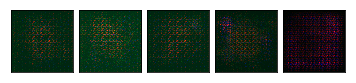

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.04337307920350748
Generator loss:     5.343306569492116


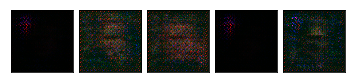

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
Discriminator loss: 0.029798306743888295
Generator loss:     6.382398016312543


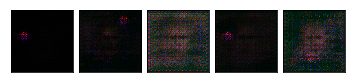

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: -0.0062682668075842015
Generator loss:     6.22370592285605


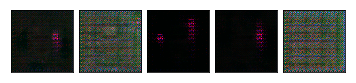

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.008576855063438416
Generator loss:     6.604871525483973


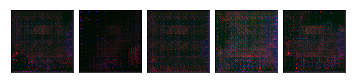

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 0.5192139020518345
Generator loss:     4.794004861046286


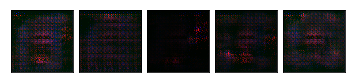

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.6325361218084308
Generator loss:     5.472027091418996


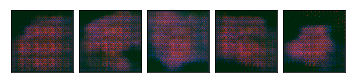

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
Discriminator loss: 0.13447504030431018
Generator loss:     4.894208655637853


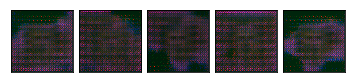

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.040225635556613695
Generator loss:     5.660396940567914


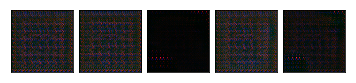

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.047269953086095697
Generator loss:     6.571218350354363


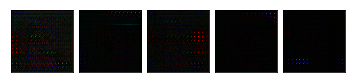

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.020767740686150157
Generator loss:     5.2153440503513115


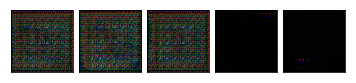

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: -0.015255728626952451
Generator loss:     7.639324412626379


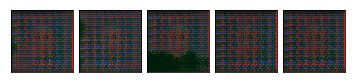

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.045614594264942056
Generator loss:     8.08137845993042


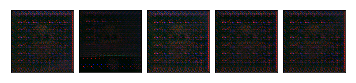

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.04501981463502435
Generator loss:     6.844830905689912


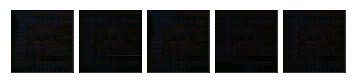

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.023763128063258004
Generator loss:     8.44227013868444


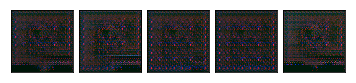

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
Discriminator loss: 0.08051241550813704
Generator loss:     7.339154748355641


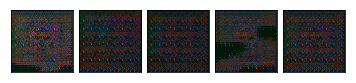

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.016209772623637143
Generator loss:     6.888915735132554


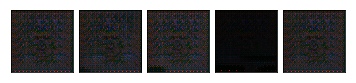

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.07239735016927999
Generator loss:     7.816019142375273


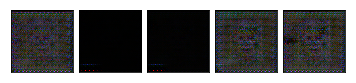

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.013764839400263393
Generator loss:     6.010928939370548


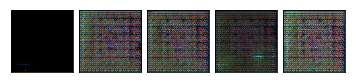

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: -0.02017183240283938
Generator loss:     6.728659798117245


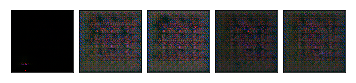

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.06418714716153986
Generator loss:     6.8022018039927765


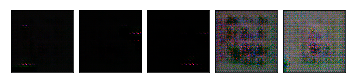

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.05762008796719944
Generator loss:     6.406471280490651


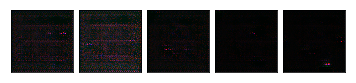

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: -0.007011687492623049
Generator loss:     6.986474457909079


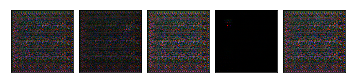

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: -0.036091420580359065
Generator loss:     9.641057435204


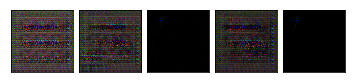

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.02018792532822665
Generator loss:     5.950643455280977


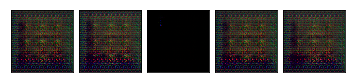

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: -0.0705841832301196
Generator loss:     7.314524987164666


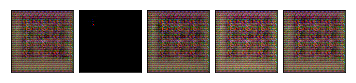

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: -0.039241999168606365
Generator loss:     7.12533151402193


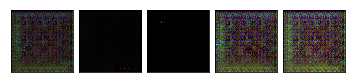

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: -0.0936489054823623
Generator loss:     8.774799431071562


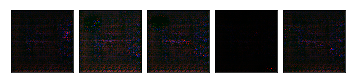

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.025156385320074418
Generator loss:     7.869483162375057


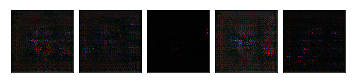

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.11546201609513339
Generator loss:     8.489414663875804


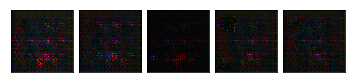

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: -0.0069596701685120076
Generator loss:     8.176399988286635


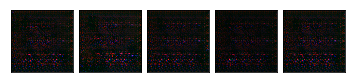

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.0982853625627125
Generator loss:     7.56887162432951


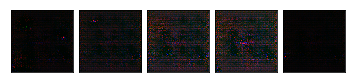

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.08197531147914774
Generator loss:     5.889291482813218


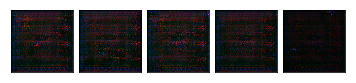

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 0.22552721596816006
Generator loss:     7.320423771353329


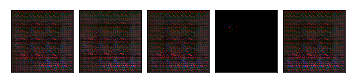

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.15229601434925022
Generator loss:     5.41245626000797


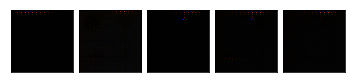

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.0620473559726687
Generator loss:     5.059643941767075


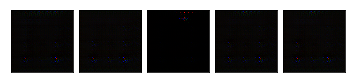

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: -0.01961734956678222
Generator loss:     6.936455726623535


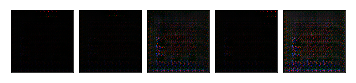

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.08734085520400721
Generator loss:     6.0452970897450165


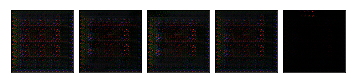

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.05965573658399722
Generator loss:     7.469976172727697


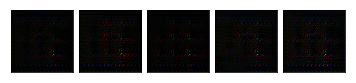

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.54it/s]
Discriminator loss: 0.05349090596770539
Generator loss:     7.005942597108729


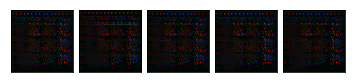

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.54it/s]
Discriminator loss: 0.07013359293341637
Generator loss:     7.029458999633789


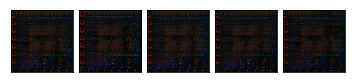

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.5482550524175167
Generator loss:     8.41114117117489


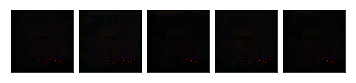

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.21320869532578132
Generator loss:     6.082512967726764


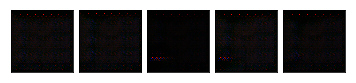

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.2869340323788278
Generator loss:     6.837479395024917


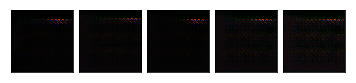

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.05786384138114312
Generator loss:     5.760356201845057


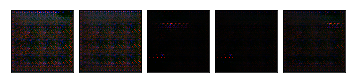

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.0035625529639861163
Generator loss:     6.737725061528823


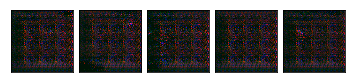

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.03845220322118086
Generator loss:     5.973210306728587


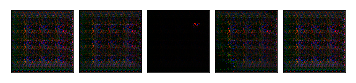

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
Discriminator loss: 0.005175964797244352
Generator loss:     6.1003084463231705


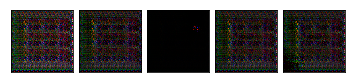

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.020089836243320915
Generator loss:     6.396373748779297


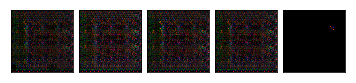

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.06367838130716015
Generator loss:     6.088382552651798


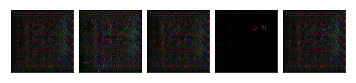

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.0011431053280830383
Generator loss:     6.161858979393454


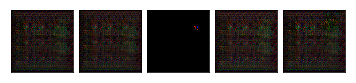

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: -0.049327964291853064
Generator loss:     6.23835558049819


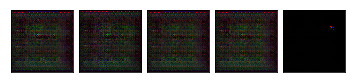

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.7540100437095937
Generator loss:     6.968926822437959


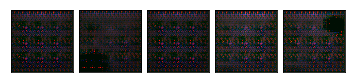

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.173129249473705
Generator loss:     6.738883523380055


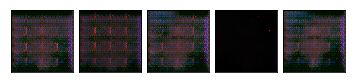

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.06457184846786891
Generator loss:     7.427610397338867


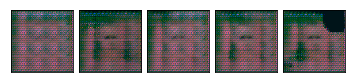

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.06452019293518628
Generator loss:     5.855861495522892


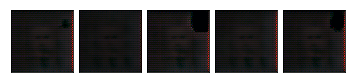

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.05827858901637442
Generator loss:     6.525064889122458


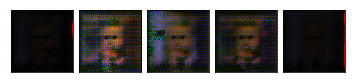

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.03383274529786671
Generator loss:     7.175274301977718


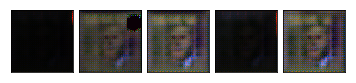

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.09806745466502274
Generator loss:     6.4379461582969215


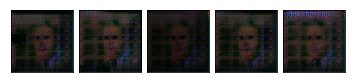

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.1596383991486885
Generator loss:     6.855433842715095


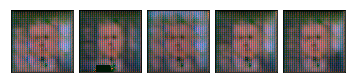

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.22648829342249563
Generator loss:     5.593580470365636


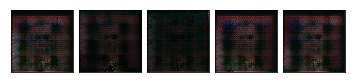

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.8913695406826103
Generator loss:     5.500900535022511


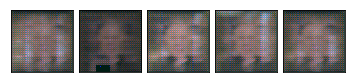

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.39052242785692215
Generator loss:     5.624660828534295


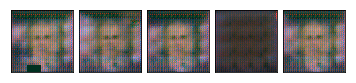

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.9620054701671881
Generator loss:     4.455034811707104


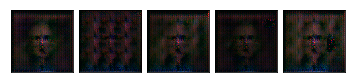

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.40207016928231015
Generator loss:     5.114592187544879


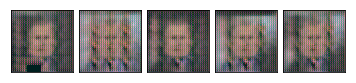

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.82it/s]
Discriminator loss: 0.09900090273688822
Generator loss:     5.041566456065459


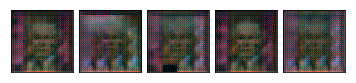

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.06180914327063981
Generator loss:     5.313547078300925


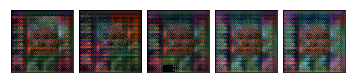

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.06906207935775027
Generator loss:     7.14774367388557


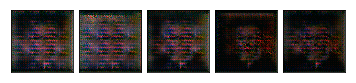

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.8212632423485903
Generator loss:     5.294445388457355


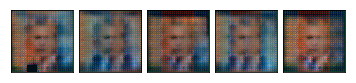

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.6002338340177256
Generator loss:     5.334560296114753


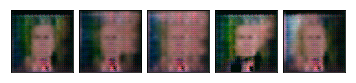

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.1333739679745015
Generator loss:     5.273273257648244


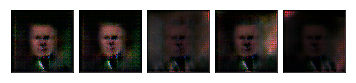

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.5676884006927995
Generator loss:     5.40719004238353


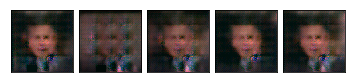

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.4300670961246771
Generator loss:     4.125395283979528


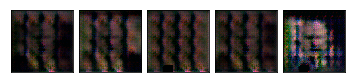

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.2304815921713324
Generator loss:     6.169162371579339


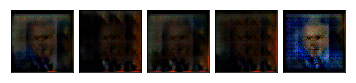

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.5967277917353546
Generator loss:     6.266514890334186


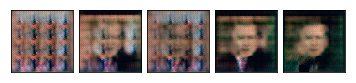

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.2137897619429756
Generator loss:     5.09917231167064


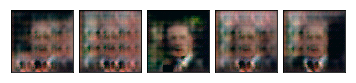

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.7603314948432586
Generator loss:     5.370715884601369


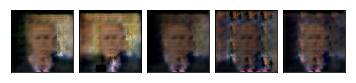

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.5392525757060331
Generator loss:     4.49644142739913


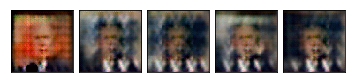

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.005133866387255
Generator loss:     3.798244504367604


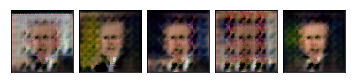

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0153828605132944
Generator loss:     4.086269154268153


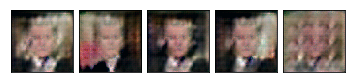

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.9764222642954659
Generator loss:     2.6894757449626923


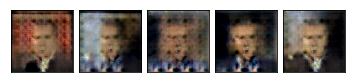

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.8500367420561173
Generator loss:     3.5975562193814445


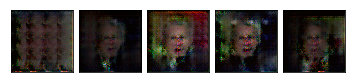

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.9849065752590404
Generator loss:     3.388925173703362


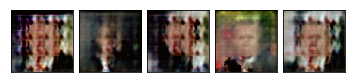

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 1.0925352275371552
Generator loss:     2.671830752316643


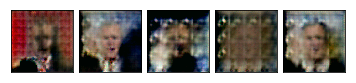

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0067466357175041
Generator loss:     2.735256889287163


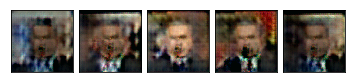

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.9540124114821938
Generator loss:     2.7733229749342976


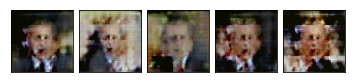

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0438710556310766
Generator loss:     2.52579988451565


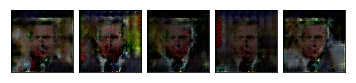

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.0676206104895647
Generator loss:     2.6649424889508415


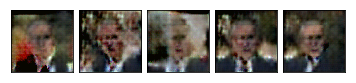

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 1.064867450910456
Generator loss:     2.568227431353401


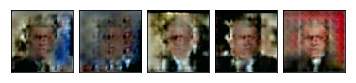

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.72it/s]
Discriminator loss: 0.8599659081767587
Generator loss:     2.72970090192907


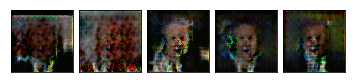

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.9129217196913326
Generator loss:     2.7760386256610645


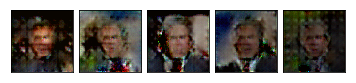

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.8821053259512958
Generator loss:     3.1503102288526645


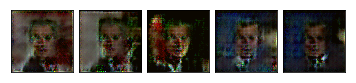

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.870276540517807
Generator loss:     3.127630829811096


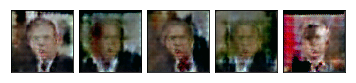

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.8045920764698702
Generator loss:     2.8739982142167935


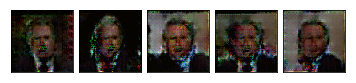

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.9613469874157625
Generator loss:     3.182758429471184


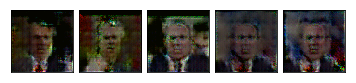

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.7383754393633675
Generator loss:     3.157794482567731


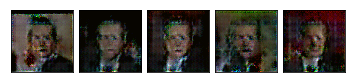

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0016381267239065
Generator loss:     3.0649244224323944


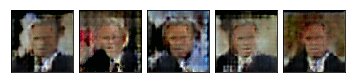

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.7533128647243276
Generator loss:     3.121008922072018


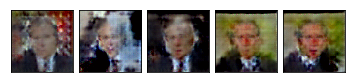

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.8548536335720736
Generator loss:     3.100639925283544


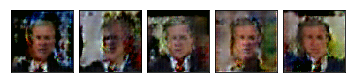

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.7703196792041554
Generator loss:     3.407047425999361


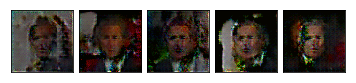

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


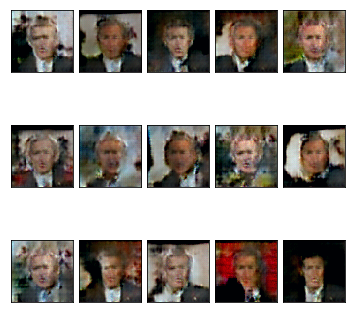

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
#from cs236605.answers import display_answer
#import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
#display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
#display_answer(hw3.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
#display_answer(hw3.answers.part3_q3)